# Deep Learning Part 2 : Homework 2
## Generative Models - Autoencoders and GANs [60 pts]
**GEC Academy: Winter 2019**  
**Instructor**: Pavlos Protopapas 
**TFs :** Patrick Ohiomoba, Srivatsan Srinivasan

---

### INSTRUCTIONS

- Please include the group number on the assignment
- Please also include the names of all collaborators.
- Make sure all work is contained in the submitted Jupyter Notebook
- Give credit to any  external sources such as blog posts, papers, and source code used in your answers. 
- Plagiarism in any form is not allowed.

---

** Names of all collaborators/group members: ** Yunfan He, Zhilin Zhang, Shengcheng Yu, Haoyue Du

** Group Number: ** 2

## Report

Students should in addition ot this notebook submit a written report, in which they should detail their explorations of the problems in this Homework in a more formal format.  The final report should be approximately 6 pages, double-spaced, single column. The report format should follow a standard research paper format in terms of organization and include the following sections:

- Introduction including motivations and related Work
- Methods
- Results
- Conclusion


## Tools

### Import all modules

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import random
import zipfile
import pandas
import pandas as pd
import os 
import csv
import numpy as np
import scipy
import progressbar
import keras
from tqdm import tqdm_notebook
from keras.preprocessing import image, sequence
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout
from keras.layers import LSTM, SimpleRNN, Input, Flatten, Dense, Activation, Conv2D, MaxPooling2D, Reshape, UpSampling2D, InputLayer
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.utils import np_utils, to_categorical
from sklearn.model_selection import train_test_split
# fix random seed for reproducibility
np.random.seed(1)

Using TensorFlow backend.


### Clear all existing models

In [0]:
keras.backend.clear_session()

## Problem 1: Making Faces [55 pts]

We'll be using a subset of the Celeb A dataset to help us build facial generative models.  As described [on the Celeb A site](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

> CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. CelebA has large diversities, large quantities, and rich annotations, including

> - 10,177 number of identities,
> - 202,599 number of face images, and
> - 5 landmark locations, 40 binary attributes annotations per image.

### Part A: Preparing the Data [5 pts]

**1.A.1.** In the provided data you'll see the `img_align_celeba` directory. The images in that directory will form your dataset.  You may want to create a [Keras Custom Data Generator](https://techblog.appnexus.com/a-keras-multithreaded-dataframe-generator-for-millions-of-image-files-84d3027f6f43).  

**1.A.2.** Load the attribute data in `list_attr_celeba.txt` into a pandas dataframe.

**1.A.3.** Pick 3 random images from the dataset, plot them, and verify that the attributes are accurate.

### 1.A Answers
***
**1.A.1 Getting dataset `img_align_celeba`**  

Download the `img_align_celeba` dataset and attribute data `list_attr_celeba.txt`.  
All 202599 images are stored in `/celeba/img_align_celeba/`.  
Attribute data is `/list_attr_celeba/list_attr_celeba.txt`

In [0]:
# Create celeba directory and download from AWS
!mkdir celeba && wget https://s3.amazonaws.com/gec-harvard-dl2-hw2-data/datasets/celeba-dataset.zip

# Download attribute data from personal GitHub repo, to list_attr_celeba/list_attr_celeba.txt
!git clone https://github.com/Yvesyingyi/list_attr_celeba.git

mkdir: cannot create directory ‘celeba’: File exists
fatal: destination path 'list_attr_celeba' already exists and is not an empty directory.


In [0]:
# Extract image files to celeba/img_align_celeba
with zipfile.ZipFile("celeba-dataset.zip","r") as celeba_ref:
  celeba_ref.extractall("celeba/")
with zipfile.ZipFile("celeba/img_align_celeba.zip") as img_align_ref:
  img_align_ref.extractall("celeba")

In [0]:
NUM_IMGS = 202599

**1.A.2 Loading the attribute data**  

Now, the attribute data in `list_attr_celeba.txt` should be loaded in a pandas dataframe. There is 1 line of header in the text file, and values are seperated by one or more whitespaces, so the parameters in function `pd.read_csv` should be set accordingly.

In [0]:
dataFrame = pd.read_csv('list_attr_celeba/list_attr_celeba.txt', header=1, delim_whitespace=True)
dataFrame

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
000006.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,1,1,-1,1,-1,-1,1
000007.jpg,1,-1,1,1,-1,-1,1,1,1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,1
000008.jpg,1,1,-1,1,-1,-1,1,-1,1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
000009.jpg,-1,1,1,-1,-1,1,1,-1,-1,-1,...,-1,1,-1,-1,1,-1,1,-1,-1,1
000010.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,1,-1,-1,1


**1.A.3 Plotting and verifying 3 random images**  

3 functions are defined here.  
`get_attributes` is to get all attributes from a certain row in the pandas dataframe, then outputs all the labels that value equals 1.  
`show_image` is to output an image with its labels for a given index.  
`check_rand_img` generates a random index and calls `show_image` on that index.

Everytime `check_rand_img` is called, the notebook will output a random images with all its attributes.

In [0]:
# get all attributes from a certain row
# usage: text = get_attributes(0)
def get_attributes(idx):
  columns = dataFrame.columns.values.tolist()
  attri = ''
  for i in range(len(columns)):
    # if the value is 1, output the attribute
    if dataFrame.iat[idx,i]==1:
      attri += columns[i] + ',\n'
  # remove last comma and newline
  return attri[:-2]


# show the image for the given row, with attributes appended
# usage: show_image(0)
def show_image(idx):
  # get filename
  filename = dataFrame.iloc[idx].name
  img = Image.open('celeba/img_align_celeba/'+ filename)
  # show figure
  fig, (fig1) = plt.subplots(1, 1, figsize=(10, 5))
  fig1.imshow(img)
  fig1.set_title(filename)
  fig1.set_axis_off()
  # set text
  fig1.text(1.02, 0, get_attributes(idx), transform=fig1.transAxes)
  fig.show()
  
# show a random image in 10000 images
def check_rand_img():
  index = random.randint(0, NUM_IMGS - 1)
  show_image(index)
  get_attributes(index)

Calling `check_rand_img` 3 times will generate 3 sample images.

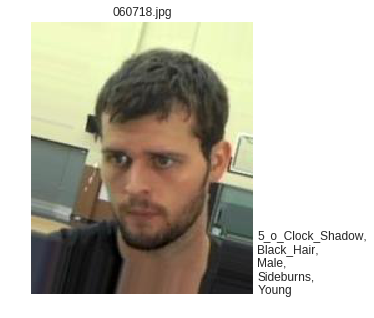

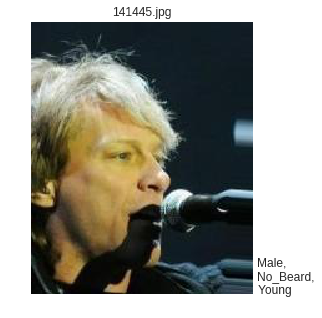

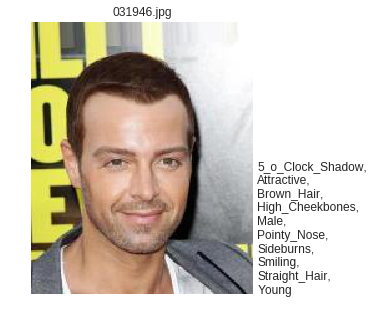

In [0]:
# show 3 random images
for i in range(3):
  check_rand_img()

***

### Part B: Building and Training a Variational Autoencoder Model [25 pts]

**1.B.1.** Create and compile a Convolutional Variational Autoencoder Model (including encoder and decoder) for the celebrity faces dataset.  Print summaries for the encoder, decoder and full autoencoder models.

**1.B.2.** Train your model on the images in the celeba dataset.

**1.B.3.** Choose a random input image.  Encode the image and then Decode the latent representation.  Plot the original image and the reconstructed output.  How do they compare?

**1.B.4.** Choose two celebrity faces from the dataset that differ according to two attributes and taking advantages of alterations of the latent representations image morph from one to the other.  See below for an example.

![](https://i.ibb.co/qyDSLfc/latent-1.png)

**1.B.5.** Generate and visualise around 15 celebrity faces not in your training set.  How do the generated faces compare in quality to celebrity faces from the training samples?

### 1.B Answers
***

In [0]:
# size of training set
INPUT_SIZE = 20000
TRAINING_RATE = 0.9

In [0]:
# 1.A.1 load data
img_list = []
# dir_path = '/Users/yushengcheng/tensorflow_datasets/celeba-dataset/img_align_celeba/'
dir_path = 'celeba/img_align_celeba/'
pic_list = os.listdir(dir_path)
for i in range(INPUT_SIZE):
    img_list.append(np.array(Image.open(dir_path + pic_list[i])))
img_array = np.array(img_list)

In [0]:
# 1.A.2 load attributes into a Pandas DataFrame
# list_attr_celeba = list(csv.reader(
#     open('/Users/yushengcheng/tensorflow_datasets/celeba-dataset/list_attr_celeba.csv')))
list_attr_celeba = list(csv.reader(open('celeba/list_attr_celeba.csv')))
attr_name = list_attr_celeba[0][1:]
list_attr_celeba.remove(list_attr_celeba[0])
pict_name = []
attr_data = []
for data in list_attr_celeba:
    pict_name.append(data[0])
    attr_data.append(data[1:])
attribute = pandas.DataFrame(np.array(attr_data), columns=attr_name, index=pict_name)

In [0]:
# 1.B.3. Choose a random input image. Encode the image and then Decode the latent representation.
#        Plot the original image and the reconstructed output. How do they compare?
# 1.B.3. 选择随机输入图像。对图像进行编码，然后对潜在表示进行解码。绘制原始图像和重建输出。他们如何比较？
#
# 1.B.4. Choose two celebrity faces from the dataset that differ according to two attributes
#        and taking advantages of alterations of the latent representations image morph from one to the other.
#        See below for an example.
# 1.B.4. 从数据集中选择两个根据两个属性而不同的名人面孔，并利用潜在表示图像变换从一个到另一个的变化。请参阅下面的示例。
#
# 1.B.5. Generate and visualise around 15 celebrity faces not in your training set.
#        How do the generated faces compare in quality to celebrity faces from the training samples?
# 1.B.5. 生成并可视化大约15个不在训练集中的名人面孔。生成的面孔如何在质量上与训练样本中的名人面孔进行比较？

# 1.B.1
train_set = img_array[0:int(TRAINING_RATE * INPUT_SIZE)]
test__set = img_array[int(TRAINING_RATE * INPUT_SIZE):INPUT_SIZE]
for i in range(int(TRAINING_RATE * INPUT_SIZE)):
  train_set[i] = train_set[i].astype('float32') / 255
for i in range(int((TRAINING_RATE-1) * INPUT_SIZE)):
  test__set[i] = test__set[i].astype('float32') / 255

In [0]:
def build_conv_encoder(input_shape):
    # Create sequential model
    conv_model = Sequential()

    # Encoder Layers
    conv_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    conv_model.add(MaxPooling2D((2, 2), padding='same'))
    conv_model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    conv_model.add(MaxPooling2D((2, 2), padding='same'))
    conv_model.add(Conv2D(8, (3, 3), strides=(2, 2), activation='relu', padding='same'))

    # Flatten encoding for bottleneck layer
    conv_model.add(Flatten(name="bottleneck"))

    return conv_model


def build_conv_decoder(bottleneck_size):
    # Create sequential model
    conv_model = Sequential()

    # Decoder Layers
    conv_model.add(InputLayer(input_shape=(bottleneck_size,)))
    conv_model.add(Reshape((28, 23, 8)))
    conv_model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    conv_model.add(UpSampling2D((2, 2)))
    conv_model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    conv_model.add(UpSampling2D((2, 2)))
    conv_model.add(Conv2D(16, (3, 3), activation='relu'))
    conv_model.add(UpSampling2D((2, 2)))
    conv_model.add(Conv2D(3, (3, 3), activation='sigmoid'))

    return conv_model


def assemble_autoencoder(input_shape, encoder, decoder):
    # assemble the inputs
    inputs = Input(shape=input_shape)

    # encode the inputs
    encoding = encoder(inputs)

    # reconstruct the input from encoding
    reconstruction = decoder(encoding)

    autoencoder = Model(inputs=inputs, outputs=reconstruction)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder

In [8]:
conv_encoder = build_conv_encoder(train_set.shape[1:])
conv_decoder = build_conv_decoder(5152)
conv_encoder.summary()
conv_decoder.summary()

conv_autoencoder = assemble_autoencoder(train_set.shape[1:], conv_encoder, conv_decoder)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 218, 178, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 109, 89, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 89, 8)        1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 45, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 23, 8)         584       
_________________________________________________________________
bottleneck (Flatten)         (None, 5152)              0         
Total params: 2,192
Trainable params: 2,192
Non-trainable params: 0
__

In [10]:
conv_autoencoder.fit(train_set, train_set, epochs=15, validation_data=[test__set, test__set])

Train on 18000 samples, validate on 2000 samples
Epoch 1/15
18000/18000 [==============================] - 64s 4ms/step - loss: 0.0118 - val_loss: -1658.6133
Epoch 2/15
18000/18000 [==============================] - 64s 4ms/step - loss: 0.0113 - val_loss: -1703.4179
Epoch 3/15
18000/18000 [==============================] - 64s 4ms/step - loss: 0.0110 - val_loss: -1679.0841
Epoch 4/15
18000/18000 [==============================] - 64s 4ms/step - loss: 0.0107 - val_loss: -1708.7610
Epoch 5/15
18000/18000 [==============================] - 64s 4ms/step - loss: 0.0104 - val_loss: -1690.4307
Epoch 6/15
18000/18000 [==============================] - 64s 4ms/step - loss: 0.0100 - val_loss: -1712.0450
Epoch 7/15
18000/18000 [==============================] - 65s 4ms/step - loss: 0.0098 - val_loss: -1729.7770
Epoch 8/15
18000/18000 [==============================] - 64s 4ms/step - loss: 0.0096 - val_loss: -1736.4955
Epoch 9/15
18000/18000 [==============================] - 64s 4ms/step - loss: 

In [0]:
num_images = 10
random_test_images = np.random.randint(test__set.shape[0], size=num_images)

conv_encoded_imgs = conv_encoder.predict(test__set)
conv_decoded_imgs = conv_autoencoder.predict(test__set)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    ax.set_axis_off()
    plt.imshow(test__set[image_idx].reshape(218, 178, 3))
    plt.gray()

    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    ax.set_axis_off()
    plt.imshow(conv_encoded_imgs[image_idx].reshape(56, 92))
    plt.gray()

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2 * num_images + i + 1)
    ax.set_axis_off()
    plt.imshow(conv_decoded_imgs[image_idx].reshape(218, 178, 3))
    plt.gray()
plt.show()

***

## Problem 2: VAEGANIME [45 pts]

Wikipedia describes [Anime]() as follows:

> Anime is hand-drawn and computer animation originating from or associated with Japan.  

> The word anime is the Japanese term for animation, which means all forms of animated media.Outside Japan, anime refers specifically to animation from Japan or as a Japanese-disseminated animation style often characterized by colorful graphics, vibrant characters and fantastical themes. The culturally abstract approach to the word's meaning may open up the possibility of anime produced in countries other than Japan For simplicity, many Westerners strictly view anime as a Japanese animation product. Some scholars suggest defining anime as specifically or quintessentially Japanese may be related to a new form of Orientalism

We've provided you a dataset of anime faces and we want you to create a model to generate faces in the same style using a special form of GAN, a VAE-GAN.  The term VAE-GAN was first used by Larsen et. al in their paper [“Autoencoding beyond pixels using a learned similarity metric”](https://arxiv.org/abs/1512.09300).  VAE-GAN models differentiate themselves from GANs in that their generators are variation autoencoders.

![](https://cdn-images-1.medium.com/max/800/0*KEmfTtghsCDu6UTb.png)

### Part A: Preparing the Data [5 pts]

**2.A.1.** We've provided you over 20K anime faces in the form of 64x64 images.  Use them to create your anime face dataset.  You may find it to your advantage to create a [Keras Custom Data Generator](https://techblog.appnexus.com/a-keras-multithreaded-dataframe-generator-for-millions-of-image-files-84d3027f6f43).

### 2.A Answers: Preparing the data
***

**2.A.1 Preparing png files**  

Download and store all 21551 png images in directory `/anime-faces/data/`  
(`1.png` to `21551.png`)

For Google Colab, download all the images: {

In [0]:
# Create celeba directory and download from AWS
!mkdir anime-faces && wget https://s3.amazonaws.com/gec-harvard-dl2-hw2-data/datasets/anime-faces.zip

mkdir: cannot create directory ‘anime-faces’: File exists


In [0]:
with zipfile.ZipFile("anime-faces.zip","r") as anime_ref:
  anime_ref.extractall("anime-faces/")

}  

If the notebook is in local runtime, just download and store all 21551 png images in directory `/anime-faces/data/`.  
Then, store png images in numpy variables.

In [0]:
img_list = []
dir_path = 'anime-faces/data/'

pic_list = os.listdir(dir_path)
for i in range(21551):
    img_list.append(np.array(Image.open(dir_path + pic_list[i])))
img_array = np.array(img_list)
print("Dataset size: ", img_array.shape[0])
print("Image dimension: ", img_array.shape[1:])

Dataset size:  21551
Image dimension:  (64, 64, 3)


Split training data and testing data, with a ratio of 3 to 1:

In [0]:
train_imgs, test_imgs = train_test_split(img_array)
print("Training set size: ", train_imgs.shape[0])
print("Testing set size: ", test_imgs.shape[0])

Training set size:  16163
Testing set size:  5388


Plot 3 random images and check the output:

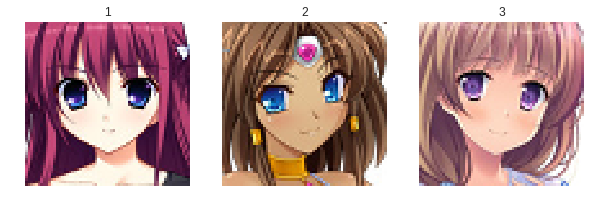

In [0]:
fig, (fig1,fig2,fig3) = plt.subplots(1, 3, figsize=(10, 5))
fig1.imshow(img_array[random.randint(0, 21551 - 1)])
fig1.set_title(1)
fig1.set_axis_off()
fig2.imshow(img_array[random.randint(0, 21551 - 1)])
fig2.set_title(2)
fig2.set_axis_off()
fig3.imshow(img_array[random.randint(0, 21551 - 1)])
fig3.set_title(3)
fig3.set_axis_off()
fig.show()

Then, normalize the pixel value of images.

In [0]:
# size
IMG_WIDTH = img_array.shape[1]
IMG_HEIGHT = img_array.shape[2]
COLOR_CHANNELS = img_array.shape[3]

NUM_PIXELS = IMG_WIDTH * IMG_HEIGHT * COLOR_CHANNELS
print("NUM_PIXELS = ", NUM_PIXELS)

NUM_PIXELS =  12288


In [0]:
# Rescale data since we are using ReLU activations.
train_imgs = train_imgs.reshape(16163, NUM_PIXELS)
test_imgs = test_imgs.reshape(5388, NUM_PIXELS)
train_imgs = train_imgs.astype('float32')/255
test_imgs = test_imgs.astype('float32')/255

Now all the images are correctly handled.

***

### Part B: Building and Training a DCGAN [20 pts]

**2.B.1.** Create and compile a DCGAN model for the anime faces dataset.  Print summaries for the generator and discriminator models

**2.B.2.** Train your model on the images in the anime faces dataset.

**2.B.3.** Generate and visualise around 15 anime faces not in your training set.  How do the generated faces compare in quality to anime faces from the training samples?

### 2.B Answers: Building DCGAN
***

#### 2.B.1 Create DCGAN Model

In [0]:
# noise vector
z_dim = 300

In [0]:
def leakyReLU(x,neg_scale=0.01):
  if x > 0:
    return x
  else:
    return neg_scale*x

In [0]:
adam = Adam(lr=0.0002, beta_1=0.5)


#GENERATOR
g = Sequential()
g.add(Dense(256, input_dim=z_dim, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(1024, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(NUM_PIXELS, activation='sigmoid'))  # Values between 0 and 1
g.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

#DISCRIMINATOR
d = Sequential()
d.add(Dense(1024, input_dim=NUM_PIXELS, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(1, activation='sigmoid'))  # Values between 0 and 1
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

#GAN
d.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [0]:
g.summary()
d.summary()
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               77056     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_4 (Dense)              (None, 12288)             12595200  
Total params: 13,329,152
Trainable params: 13,329,152
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              12583936  
________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


#### 2.B.2 Training and generating images

In [0]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, IMG_WIDTH, IMG_HEIGHT, COLOR_CHANNELS)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [0]:
losses = {"D":[], "G":[]}

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    batchCount = int(train_imgs.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in tqdm_notebook(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm_notebook(range(batchCount)):  # tqdm_notebook(range(batchCount), leave=False):
            # Create a batch by drawing random index numbers from the training set
            image_batch = train_imgs[np.random.randint(0, train_imgs.shape[0], size=BATCH_SIZE)]
            # Create noise vectors for the generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            
            # Generate the images from the noise
            generated_images = g.predict(noise)
            X = np.concatenate((image_batch, generated_images))
            # Create labels
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9  # One-sided label smoothing

            # Train discriminator on generated images
            d.trainable = True
            d_loss = d.train_on_batch(X, y)

            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            y2 = np.ones(BATCH_SIZE)
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)

        # Only store losses from final
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Update the plots
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

Epochs: 50
Batch size: 128
Batches per epoch: 126


--------------- Epoch 1 ---------------


Instructions for updating:
Use tf.cast instead.


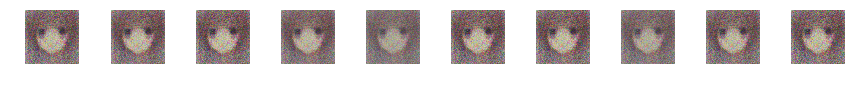

--------------- Epoch 10 ---------------


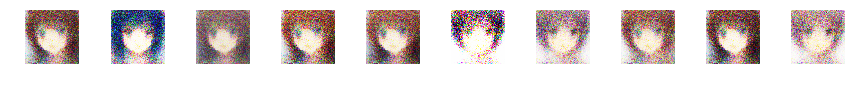

--------------- Epoch 20 ---------------


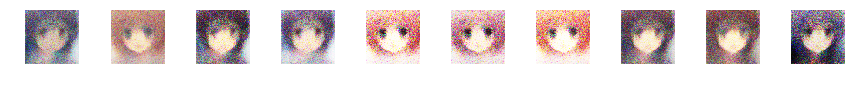

--------------- Epoch 30 ---------------


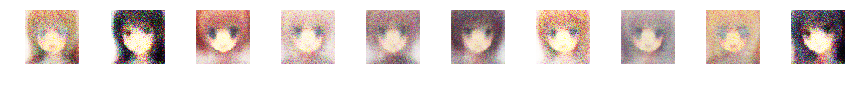

--------------- Epoch 40 ---------------


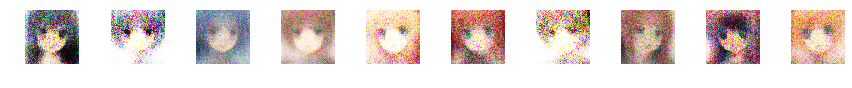

--------------- Epoch 50 ---------------


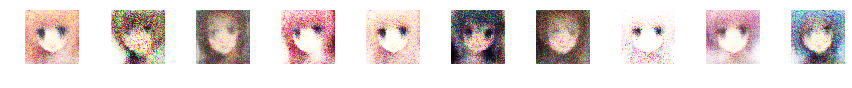

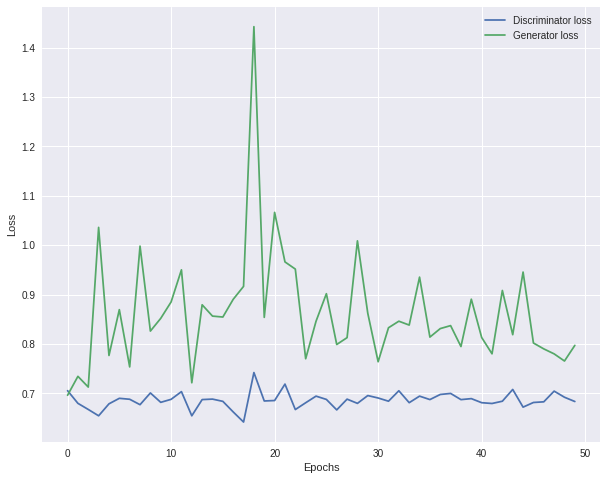

In [0]:
train(epochs=50, plt_frq=10, BATCH_SIZE=128)

#### (Testing a simple Autoencoder)

In [0]:
def build_mlp_encoder(input_size, bottleneck_size):
    mlp_model = Sequential()
    mlp_model.add(Dense(1024, activation='relu', input_shape=(input_size, )))
    mlp_model.add(Dense(512, activation='relu'))
    mlp_model.add(Dense(bottleneck_size, activation='relu'))
    return mlp_model

def build_mlp_decoder(input_size, bottleneck_size):
    mlp_model = Sequential()
    mlp_model.add(Dense(512, activation='relu', input_shape= (bottleneck_size, )))    
    mlp_model.add(Dense(1024, activation='relu'))
    mlp_model.add(Dense(input_size, activation='relu'))
    return mlp_model

In [0]:
mlp_encoder = build_mlp_encoder(12288, 300)
mlp_decoder = build_mlp_decoder(12288, 300)

In [0]:
def assemble_mlp_autoencoder(input_size, encoder, decoder):
    inputs = Input(shape=(input_size,))
    encoding = encoder(inputs)
    reconstruction = decoder(encoding)
    autoencoder = Model(inputs=inputs, outputs=reconstruction)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

In [0]:
mlp_autoencoder = assemble_mlp_autoencoder(12288, mlp_encoder, mlp_decoder)
mlp_autoencoder.fit(x=train_imgs, y=train_imgs, epochs=15,
                validation_data=[test_imgs, test_imgs])

Train on 16163 samples, validate on 5388 samples
Epoch 1/15
16163/16163 [==============================] - 21s 1ms/step - loss: 0.0361 - val_loss: 0.0343
Epoch 2/15
16163/16163 [==============================] - 20s 1ms/step - loss: 0.0331 - val_loss: 0.0341
Epoch 3/15
16163/16163 [==============================] - 20s 1ms/step - loss: 0.0322 - val_loss: 0.0325
Epoch 4/15
16163/16163 [==============================] - 20s 1ms/step - loss: 0.0307 - val_loss: 0.0317
Epoch 5/15
16163/16163 [==============================] - 20s 1ms/step - loss: 0.0299 - val_loss: 0.0307
Epoch 6/15
16163/16163 [==============================] - 20s 1ms/step - loss: 0.0293 - val_loss: 0.0301
Epoch 7/15
16163/16163 [==============================] - 20s 1ms/step - loss: 0.0288 - val_loss: 0.0302
Epoch 8/15
16163/16163 [==============================] - 20s 1ms/step - loss: 0.0283 - val_loss: 0.0288
Epoch 9/15
16163/16163 [==============================] - 20s 1ms/step - loss: 0.0281 - val_loss: 0.0299
Epoch 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

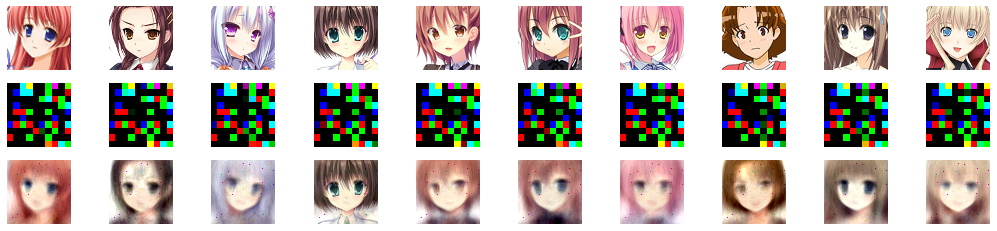

In [0]:
num_images = 10
random_test_images = np.random.randint(test_imgs.shape[0], size=num_images)

encoded_imgs = mlp_encoder.predict(test_imgs)
decoded_imgs = mlp_autoencoder.predict(test_imgs)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(test_imgs[image_idx].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(10, 10, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

***

### Part C: Building and Training a VAE-GAN [20 pts]

**2.C.1.** Create and compile a VAE-GAN model for the anime faces dataset.  Print summaries for the encoder, decoder and discriminator models

**2.C.2.** Train your model on the images in the anime faces dataset.

**2.C.3.** Generate and visualise around 15 anime faces not in your training set.  How do the generated faces compare in quality to anime faces from the training samples? How do they compare to the faces from the traditional GAN.

### 2.C Answers
***

**2.C.1 Building a VAE-GAN model**

In [0]:
# size
IMG_WIDTH = img_array.shape[1]
IMG_HEIGHT = img_array.shape[2]
COLOR_CHANNELS = img_array.shape[3]

NUM_PIXELS = IMG_WIDTH * IMG_HEIGHT * COLOR_CHANNELS
print("NUM_PIXELS = ", NUM_PIXELS)

NUM_PIXELS =  12288


In [0]:
# Rescale data since we are using ReLU activations.
train_imgs = train_imgs.reshape(16163, NUM_PIXELS)
test_imgs = test_imgs.reshape(5388, NUM_PIXELS)
train_imgs = train_imgs.astype('float32')/255
test_imgs = test_imgs.astype('float32')/255

In [0]:
# noise vector
z_dim = 100

In [0]:
def leakyReLU(x,neg_scale=0.01):
  if x > 0:
    return x
  else:
    return neg_scale*x

In [0]:
def build_mlp_encoder(input_size, bottleneck_size):
    mlp_model = Sequential()
    mlp_model.add(Dense(1024, activation='relu', input_shape=(input_size, )))
    mlp_model.add(Dense(512, activation='relu'))
    mlp_model.add(Dense(bottleneck_size, activation='relu'))
    return mlp_model

def build_mlp_decoder(input_size, bottleneck_size):
    mlp_model = Sequential()
    mlp_model.add(Dense(512, activation='relu', input_shape= (bottleneck_size, )))    
    mlp_model.add(Dense(1024, activation='relu'))
    mlp_model.add(Dense(input_size, activation='relu'))
    return mlp_model

In [0]:
def assemble_mlp_autoencoder(input_size, encoder, decoder):
    inputs = Input(shape=(input_size,))
    encoding = encoder(inputs)
    reconstruction = decoder(encoding)
    autoencoder = Model(inputs=inputs, outputs=reconstruction)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

In [0]:
adam = Adam(lr=0.0002, beta_1=0.5)

mlp_encoder = build_mlp_encoder(12288, 100)
mlp_decoder = build_mlp_decoder(12288, 100)

#GENERATOR
g = mlp_decoder

#DISCRIMINATOR
d = Sequential()
d.add(Dense(1024, input_dim=NUM_PIXELS, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(1, activation='sigmoid'))  # Values between 0 and 1
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

#AE
inputs = Input(shape=(12288,))
encoding = mlp_encoder(inputs)
reconstruction = mlp_decoder(encoding)
autoencoder = Model(inputs=inputs, outputs=reconstruction)
autoencoder.compile(optimizer='adam', loss='mse')

#GAN
d.trainable = False
inputs = Input(shape=(100, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [0]:
mlp_encoder.summary()
d.summary()
g.summary()
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 1024)              12583936  
_________________________________________________________________
dense_16 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_17 (Dense)             (None, 100)               51300     
Total params: 13,160,036
Trainable params: 13,160,036
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 1024)              12583936  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


**2.B.2 Training**

In [0]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    image_eg = test_imgs[np.random.randint(0, test_imgs.shape[0], size=n_ex)]
    generated_images = autoencoder.predict(image_eg)
    generated_images = generated_images.reshape(n_ex, 64, 64, 3)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [0]:
losses = {"D":[], "G":[]}

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    batchCount = int(train_imgs.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in tqdm_notebook(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm_notebook(range(batchCount), leave=False):
            # Create a batch by drawing random index numbers from the training set
            image_batch = train_imgs[np.random.randint(0, train_imgs.shape[0], size=BATCH_SIZE)]

            AE_loss = autoencoder.train_on_batch(image_batch, image_batch)

            latent_data = mlp_encoder.predict(image_batch)
            
            # Generate the images from the noise
            generated_images = g.predict(latent_data)
            X = np.concatenate((image_batch, generated_images))
            # Create labels
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9  # One-sided label smoothing

            # Train discriminator on generated images
            d.trainable = True
            d_loss = d.train_on_batch(X, y)

            # Train generator
            latent_data = mlp_encoder.predict(image_batch)
            y2 = np.ones(BATCH_SIZE)
            d.trainable = False
            g_loss = gan.train_on_batch(latent_data, y2)

        # Only store losses from final
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Update the plots
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

**Training model**

Epochs: 50
Batch size: 128
Batches per epoch: 126


--------------- Epoch 1 ---------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


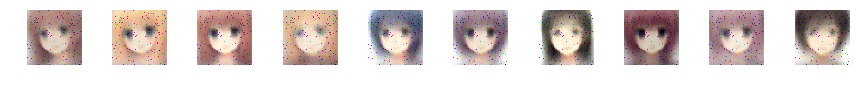

--------------- Epoch 10 ---------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


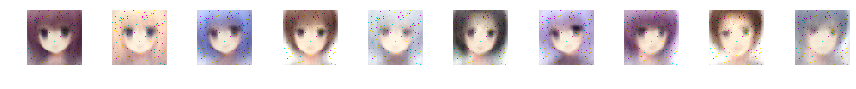

--------------- Epoch 20 ---------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

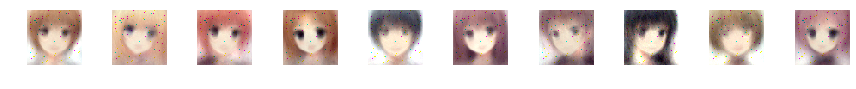

--------------- Epoch 30 ---------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

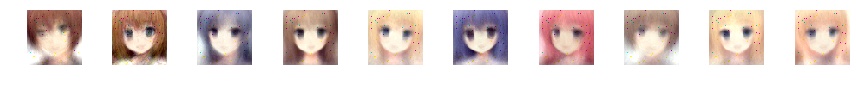

--------------- Epoch 40 ---------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

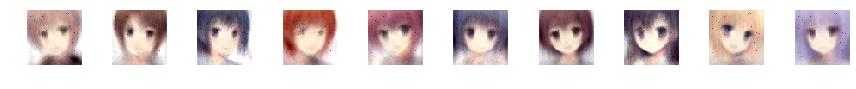

--------------- Epoch 50 ---------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


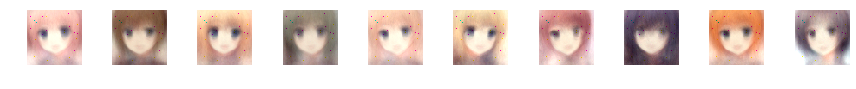

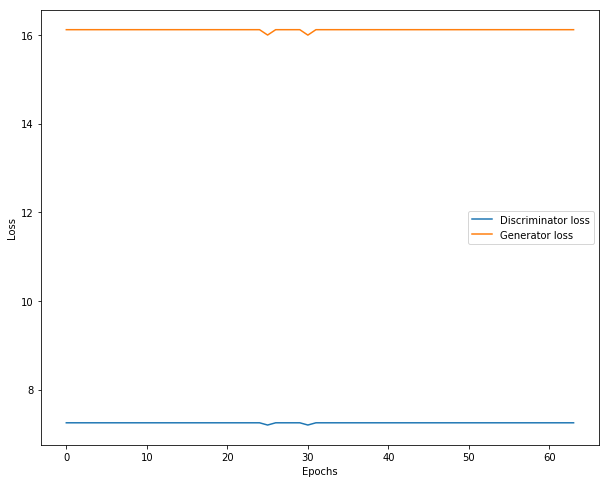

In [0]:
train(epochs=50, plt_frq=10, BATCH_SIZE=128)

***

### References

[1] GEC Labs

[2] [A Tutorial on Variational Autoencoders with a Concise Keras Implementation | Louis Tiao](https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/)